In [14]:
import os
import pandas as pd
import zipfile as zp
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'

### 1.1 Upload csv.zip file into collection of dataframes

In [74]:
def get_files_zip(path):
    '''
    Function that lists files inside the path (zip) folder
    Returns: list of paths to files
    '''
    with zp.ZipFile(path) as myzip:
        list = myzip.namelist()
    return list

def read_txt_zip(files, path):
    '''
    Function that reads files inside the path (zip) folder
    Returns: list of strings with content of corresponding files
    '''
    df = []
    for file in files:
        with zp.ZipFile(path) as myzip:
            with myzip.open(file) as myfile: df.append(myfile.read().decode('utf-8'))
    return df

In [75]:
path='./csv.zip'
files = list(filter(lambda x: '.csv' in x, get_files_zip(path)))
df = pd.DataFrame({'file': files, 'content': read_txt_zip(files, path)})
df_new = {}

for i in range(len(df)):
    a=list()
    index=df.iloc[i,1].split('\n')
    for j in range(len(index)): a.append([x for x in index[j].split(',')])
    b=pd.DataFrame(a)
    b.columns=b.iloc[0,:]
    b=b.iloc[1:,:]
    df_new.update({df.iloc[i,0].split('/')[1].split('.')[0]:b})

### 1.2 Upload json files into collection of dataframes from step before

In [76]:
import urllib, json
import requests as rqst
from bs4 import BeautifulSoup

URL='http://rhea.isegi.unl.pt:8080'
soup=BeautifulSoup(rqst.get(URL).text)

for i in soup.findAll('a'):
    response = urllib.request.urlopen(f'{URL}/{i.get("href")}')
    data = json.loads(response.read())
    df_new.update({i.get('href').split('.')[0]:pd.json_normalize(data)})

### 1.3 Upload mysql data from csv into collection of dataframes from step before

In [77]:
def getPathFiles(sPath):
    return [i for i in os.listdir(sPath) if os.path.isfile(os.path.join(sPath,i))]

In [ ]:
for e in os.listdir():
    if not (e.startswith('.') or os.path.isfile(e)):
        for f in getPathFiles(e):
            df_new.update({f.split('.')[0]:pd.read_csv(os.path.join(e,f),sep=',',encoding='utf-8')})

In [306]:
db = client["local"]

In [162]:
df_bkp=df_new['Sales_Orders'].copy()
df_new['Sales_Orders']=df_new['Sales_Orders'].convert_dtypes()

In [163]:
df_new['Sales_Orders'].dtypes

OrderID                         Int64
CustomerID                      Int64
SalespersonPersonID             Int64
PickedByPersonID                Int64
ContactPersonID                 Int64
BackorderOrderID                Int64
OrderDate                      string
ExpectedDeliveryDate           string
CustomerPurchaseOrderNumber     Int64
IsUndersupplyBackordered        Int64
Comments                        Int64
DeliveryInstructions            Int64
InternalComments                Int64
PickingCompletedWhen           string
dtype: object

In [158]:
df_new['Sales_Orders']=df_bkp.copy()

In [147]:
for key in df_new.keys():
    a=[]
    for name in df_new[key].columns:
        if not isinstance(name,type(None)):
            a.append(name)
    try:
        new=key.split('Project_WWI_')[1]
        db[new].insert_many(df_new[key].loc[:,a].to_dict('records'))
    except IndexError:
        db[key].insert_many(df_new[key].loc[:,a].to_dict('records'))
        pass
    print(f'collection {key}')

collection Project_WWI_Warehouse_Colors
collection Project_WWI_Warehouse_PackageTypes
collection Project_WWI_Warehouse_StockGroups
collection Project_WWI_Warehouse_StockItems
collection Project_WWI_Warehouse_StockItemStockGroups
collection Project_WWI_Warehouse_StockItemTransactions
collection Project_WWI_Application_Cities
collection Project_WWI_Application_Countries
collection Project_WWI_Application_DeliveryMethods
collection Project_WWI_Application_PaymentMethods
collection Project_WWI_Application_People
collection Project_WWI_Application_StateProvinces
collection Project_WWI_Application_TransactionTypes
collection Sales_CustomerCategories
collection Sales_Inovices
collection Sales_Customers
collection Purchasing_PurchaseOrders
collection Sales_Orders
collection Purchasing_PurchaseOrderLines
collection Purchasing_Suppliers
collection Sales_CustomerTransactions
collection Purchasing_SupplierTransactions
collection Sales_OrderLines
collection Purchasing_SupplierCategories
collection 

In [78]:
pd.DataFrame(df_new.items(),columns=['file','content'])

,file,content
0,Project_WWI_Warehouse_Colors,0 ColorID ColorName 1 1 Azur...
1,Project_WWI_Warehouse_PackageTypes,0 PackageTypeID PackageTypeName 1 ...
2,Project_WWI_Warehouse_StockGroups,0 StockGroupID StockGroupName 1 ...
3,Project_WWI_Warehouse_StockItems,0 StockItemID StockItem...
4,Project_WWI_Warehouse_StockItemStockGroups,0 StockItemStockGroupID StockItemID StockGro...
5,Project_WWI_Warehouse_StockItemTransactions,0 StockItemTransactionID StockItemID Tran...
6,Project_WWI_Application_Cities,CityID CityName StateProvinceID \...
7,Project_WWI_Application_Countries,CountryID CountryName ...
8,Project_WWI_Application_DeliveryMethods,DeliveryMethodID DeliveryMethodNa...
9,Project_WWI_Application_PaymentMethods,PaymentMethodID PaymentMethodName 0 ...


In [179]:
from pymongo import MongoClient
from bson.objectid import ObjectId
from pprint import pprint

host="rhea.isegi.unl.pt"
port="27044"
user="GROUP_27"
password="841604675h8960303529464l24011g49"
protocol="mongodb"
client = MongoClient(f"{protocol}://{user}:{password}@{host}:{port}")
db = client["local"]
print(client.list_database_names())

['Modeling', 'admin', 'config', 'local']


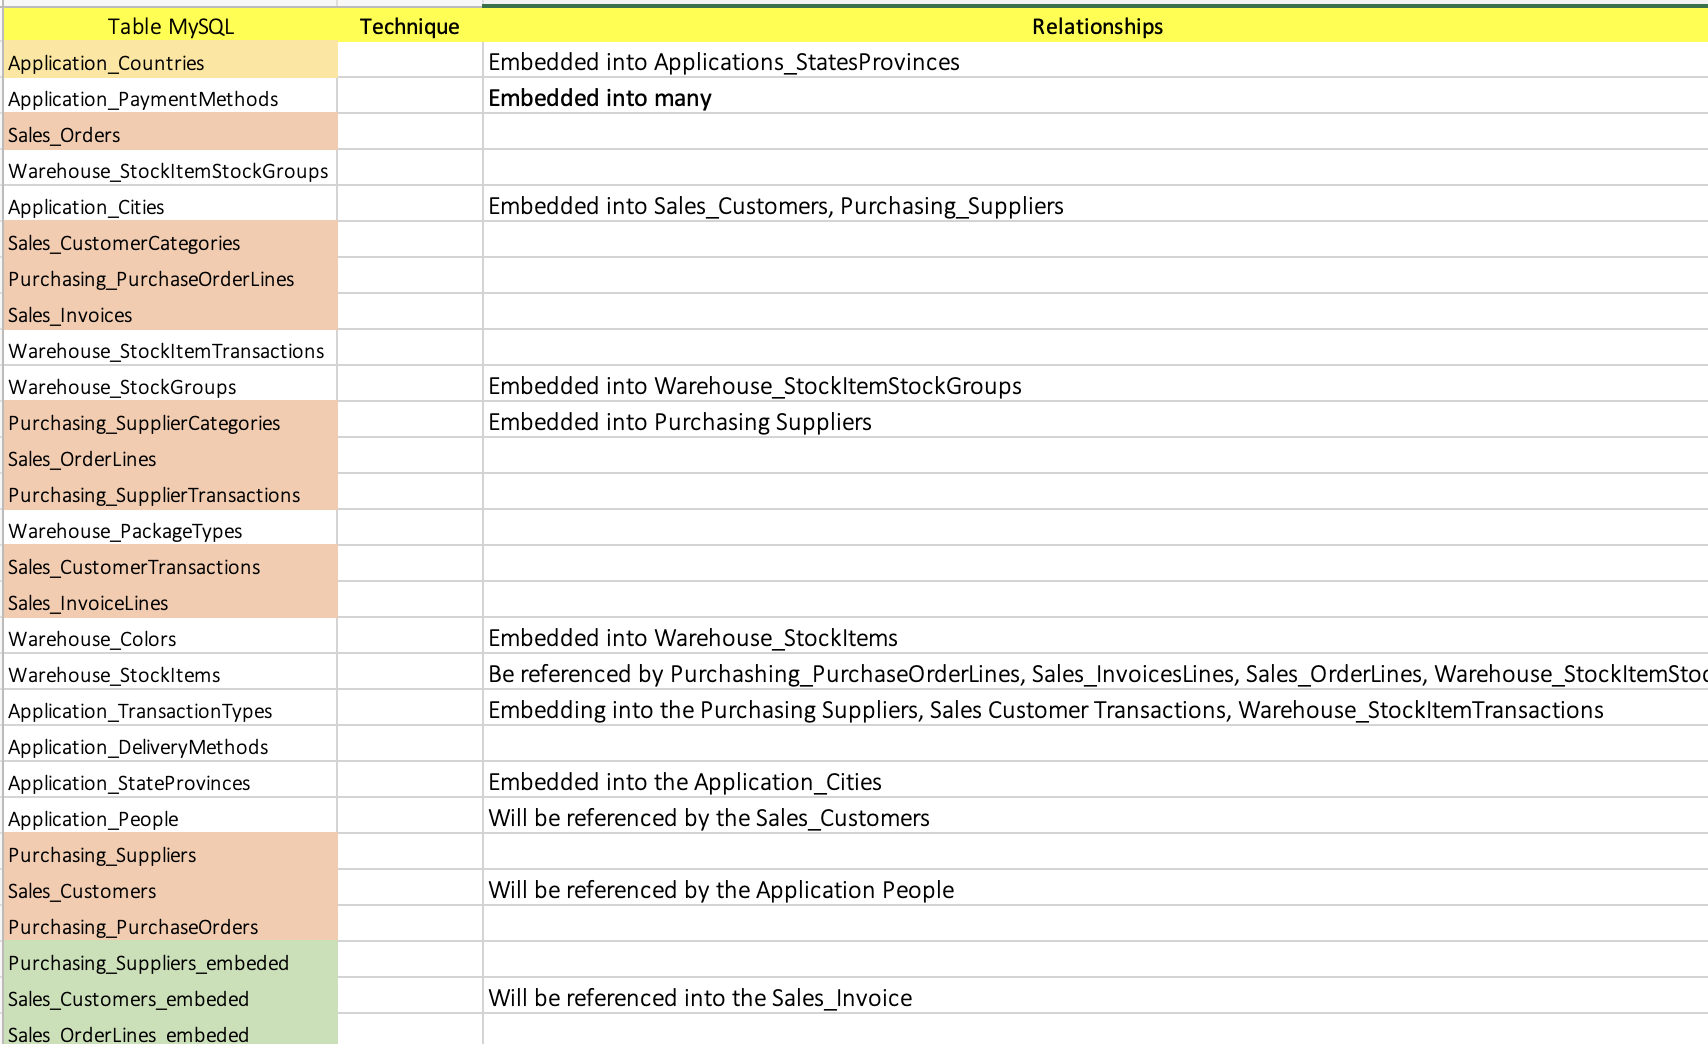

### Purchasing_Suppliers & Purchasing_SupplierCategories

In [ ]:
purchase = df_new['Purchasing_Suppliers'].copy()
df_bkp=df_new[names[0]].copy()

In [30]:
names=['Purchasing_SupplierCategories']
for n in names:
    for i in df_new[n].columns:
        df_new[n][i] = df_new[n][i].astype(str)

SupplierCategoryID      object
SupplierCategoryName    object
dtype: object

In [165]:
dict_purchase = df_new['Purchasing_Suppliers'].to_dict('records')

In [176]:
import numpy as np
from bson import ObjectId

class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, ObjectId):
            return str(obj)
        else:
            return json.JSONEncoder.default(self, obj)

In [495]:
def embedd_data(df,name,target,field):
    #args[0]:source | args[1]:target | args[3]: key  source | args [4]: collection name target
    for i in range(len(target)):
        data=int(target[i][field])
        if len(str(data))>0:
            if isinstance(data,dict): data=data[field]
            index = df[name][df[name][field].isin([data])].index[0]
            target[i][field] = df[name].iloc[index,:].to_dict()
    data_dict = json.dumps(target,cls=CustomEncoder)
    data_dict  = json.loads(data_dict)
    return data_dict

In [186]:
def embedd_data_org(dictionary, fieldname):
    for i in range(len(dict_purchase)):
        value = int(dict_purchase[i]['SupplierCategoryID'])
        index = df_new[names[0]][df_new[names[0]]['SupplierCategoryID'].isin([value])].index[0]
        dict_purchase[i]['SupplierCategoryID'] = df_new[names[0]].iloc[index,:].to_dict()

In [180]:
r=db.Purchasing_Suppliers_1.insert_many(data_dict_final)

In [181]:
db.Purchasing_Suppliers_1.find_one()

{'_id': '60b3da7bf5588b0fc1192b6d',
 'SupplierID': 1,
 'SupplierName': 'A Datum Corporation',
 'SupplierCategoryID': {'SupplierCategoryID': 2,
  'SupplierCategoryName': 'Novelty Goods Supplier'},
 'PrimaryContactPersonID': 21,
 'AlternateContactPersonID': 22,
 'DeliveryMethodID': 7.0,
 'DeliveryCityID': 38171,
 'PostalCityID': 38171,
 'SupplierReference': 'AA20384',
 'BankAccountName': 'A Datum Corporation',
 'BankAccountBranch': 'Woodgrove Bank Zionsville',
 'BankAccountCode': 356981,
 'BankAccountNumber': 8575824136,
 'BankInternationalCode': 25986,
 'PaymentDays': 14,
 'InternalComments': nan,
 'PhoneNumber': '(847) 555-0100',
 'FaxNumber': '(847) 555-0101',
 'WebsiteURL': 'http://www.adatum.com',
 'DeliveryAddressLine1': 'Suite 10',
 'DeliveryAddressLine2': '183838 Southwest Boulevard',
 'DeliveryPostalCode': 46077,
 'DeliveryLocationLat': 39.9509,
 'DeliveryLocationLong': -86.2619,
 'PostalAddressLine1': 'PO Box 1039',
 'PostalAddressLine2': 'Surrey',
 'PostalPostalCode': 46077}

### Application Countries & Application State_Provinces

In [198]:
sname=['Project_WWI_Application_Countries','Project_WWI_Application_StateProvinces']
dic_sp=df_new[sname[1]].to_dict('records')

In [199]:
dic_spnew=embedd_data(df_new,sname[0],dic_sp,'CountryID')

In [203]:
r=db.Application_StateProvinces_1.insert_many(dic_spnew)
db.Application_StateProvinces_1.find_one()

{'_id': ObjectId('60b3e851f5588b0fc1192b7b'),
 'StateProvinceID': 1,
 'StateProvinceCode': 'AL',
 'StateProvinceName': 'Alabama',
 'CountryID': {'CountryID': 230,
  'CountryName': 'United States',
  'FormalName': 'United States of America',
  'IsoAlpha3Code': 'USA',
  'IsoNumericCode': 840,
  'CountryType': 'UN Member State',
  'LatestRecordedPopulation': 313973000,
  'Continent': 'North America',
  'Region': 'Americas',
  'Subregion': 'Northern America'},
 'SalesTerritory': 'Southeast',
 'LatestRecordedPopulation': 5437278}

### Application State_Provinces & Application Cities

In [206]:
sname=['Project_WWI_Application_StateProvinces','Project_WWI_Application_Cities']
dic_ac=df_new[sname[1]].to_dict('records')

In [207]:
dic_ac_new=embedd_data(df_new,sname[0],dic_ac,'StateProvinceID')

In [208]:
r=db.Application_Cities_1.insert_many(dic_ac_new)
db.Application_Cities_1.find_one()

{'_id': ObjectId('60b3ea37f5588b0fc1192bb0'),
 'CityID': 1,
 'CityName': 'Aaronsburg',
 'StateProvinceID': {'StateProvinceID': 39,
  'StateProvinceCode': 'PA',
  'StateProvinceName': 'Pennsylvania',
  'CountryID': 230,
  'SalesTerritory': 'Mideast',
  'LatestRecordedPopulation': 13284753},
 'Location': '0xE6100000010C07E11B542C73444087C09140035D53C0',
 'LatestRecordedPopulation': 613.0}

### Remvoing NaN columns

In [219]:
df_new=df_bkp.copy()

In [272]:
def remove_nan_col(df):
    for key in df.keys():
        a=[]
        for name in df[key].columns:
            if not isinstance(name,type(None)):
                a.append(name)
        df[key]=df[key].loc[:,a]

### Warehouse_Colors & Warehouse_StockItems

In [388]:
sname=['Project_WWI_Warehouse_Colors','Project_WWI_Warehouse_StockItems']
dic_ws=df_new[sname[1]].to_dict('records')

In [466]:
dic_ws=embedd_data(df_new,sname[0],dic_ws,'ColorID')
r=db.Warehouse_StockItems_1.insert_many(dic_ws)
db.Warehouse_StockItems_1.find_one()

{'_id': ObjectId('60b3fc75f5588b0fc119c7df'),
 'StockItemID': '1',
 'StockItemName': 'USB missile launcher (Green)',
 'SupplierID': '12',
 'ColorID': '',
 'UnitPackageID': '7',
 'OuterPackageID': '7',
 'Brand': '',
 'Size': '',
 'LeadTimeDays': '14',
 'QuantityPerOuter': '1',
 'IsChillerStock': 'false',
 'Barcode': '',
 'TaxRate': '15.000',
 'UnitPrice': '25.00',
 'RecommendedRetailPrice': '37.38',
 'TypicalWeightPerUnit': '0.300',
 'MarketingComments': 'Complete with 12 projectiles',
 'InternalComments': '',
 'Photo': '',
 'SearchDetails': 'USB missile launcher (Green) Complete with 12 projectiles'}

In [382]:
df_new=df_bkp.copy()
remove_nan_col(df_new)

In [416]:
for i in df_new.keys():
     df_new[i]=df_new[i].reset_index(drop=True)

In [385]:
df_new['Project_WWI_Warehouse_StockItems'].loc[39,'ColorID']='35'
df_new['Project_WWI_Warehouse_StockItems'].loc[40,'ColorID']='3'
df_new['Project_WWI_Warehouse_StockItems'].drop(index=227,axis=0,inplace=True)

### Purchasing Suppliers & Sales Customer Transactions & Warehouse_StockItemTransactions

In [408]:
sname=['Project_WWI_Application_TransactionTypes','Sales_CustomerTransactions']
dic_ct=df_new[sname[1]].to_dict('records')

In [409]:
dic_ct=embedd_data(df_new,sname[0],dic_ct,'TransactionTypeID')
r=db.Sales_CustomerTransactions_1.insert_many(dic_ct)
db.Sales_CustomerTransactions_1.find_one()

{'_id': ObjectId('60b3fff0f5588b0fc11a93e2'),
 'CustomerTransactionID': 2,
 'CustomerID': 832,
 'TransactionTypeID': {'TransactionTypeID': 1,
  'TransactionTypeName': 'Customer Invoice'},
 'InvoiceID': 1.0,
 'PaymentMethodID': nan,
 'TransactionDate': '2013-01-01',
 'AmountExcludingTax': 2300.0,
 'TaxAmount': 345.0,
 'TransactionAmount': 2645.0,
 'OutstandingBalance': 0.0,
 'FinalizationDate': '2013-01-02',
 'IsFinalized': 1}

In [462]:
sname=['Project_WWI_Application_TransactionTypes','Project_WWI_Warehouse_StockItemTransactions']
dic_wi=df_new[sname[1]].to_dict('records')

In [465]:
dic_wi=embedd_data(df_new,sname[0],dic_wi,'TransactionTypeID')
r=db.Warehouse_StockItemTransactions_1.insert_many(dic_wi)
db.Warehouse_StockItemTransactions_1.find_one()

{'_id': ObjectId('60b4057bf5588b0fc11b5f02'),
 'StockItemTransactionID': '1',
 'StockItemID': '67',
 'TransactionTypeID': {'TransactionTypeID': 10,
  'TransactionTypeName': 'Stock Issue'},
 'CustomerID': '832',
 'InvoiceID': '1',
 'SupplierID': '',
 'PurchaseOrderID': '',
 'TransactionOccurredWhen': '2013-01-01 12:00:00.0000000',
 'Quantity': '-10.000'}

### Project_WWI_Application_DeliveryMethods & Purchasing_PurchaseOrders

In [483]:
sname=['Project_WWI_Application_DeliveryMethods','Purchasing_PurchaseOrders']
dic_po=df_new[sname[1]].to_dict('records')

In [484]:
dic_po=embedd_data(df_new,sname[0],dic_po,'DeliveryMethodID')
r=db.Purchasing_PurchaseOrders_1.insert_many(dic_po)
db.Purchasing_PurchaseOrders_1.find_one()

{'_id': ObjectId('60b408c5f5588b0fc11f0503'),
 'PurchaseOrderID': 1,
 'SupplierID': 2,
 'OrderDate': '2013-01-01',
 'DeliveryMethodID': {'DeliveryMethodID': 9,
  'DeliveryMethodName': 'Refrigerated Road Freight'},
 'ContactPersonID': 2,
 'ExpectedDeliveryDate': '2013-01-15',
 'SupplierReference': 'B2084020',
 'IsOrderFinalized': 1,
 'Comments': nan,
 'InternalComments': nan}

### Sales_CustomerCategories & Sales_Customers

In [489]:
sname=['Sales_CustomerCategories','Sales_Customers']
dic_sc=df_new[sname[1]].to_dict('records')

In [494]:
dic_sc=embedd_data(df_new,sname[0],dic_sc,'CustomerCategoryID')
r=db.Sales_Customers_1.insert_many(dic_sc)
db.Sales_Customers_1.find_one()

{'_id': ObjectId('60b40af0f5588b0fc11f0d1d'),
 'CustomerID': 1,
 'CustomerName': 'Tailspin Toys (Head Office)',
 'BillToCustomerID': 1,
 'CustomerCategoryID': {'CustomerCategoryID': 3,
  'CustomerCategoryName': 'Novelty Shop'},
 'PrimaryContactPersonID': 1001,
 'AlternateContactPersonID': 1002.0,
 'DeliveryMethodID': 3,
 'DeliveryCityID': 19586,
 'PostalCityID': 19586,
 'CreditLimit': nan,
 'AccountOpenedDate': '2013-01-01',
 'StandardDiscountPercentage': 0.0,
 'IsStatementSent': 0,
 'IsOnCreditHold': 0,
 'PaymentDays': 7,
 'PhoneNumber': '(308) 555-0100',
 'FaxNumber': '(308) 555-0101',
 'DeliveryRun': nan,
 'RunPosition': nan,
 'WebsiteURL': 'http://www.tailspintoys.com',
 'DeliveryAddressLine1': 'Shop 38',
 'DeliveryAddressLine2': '1877 Mittal Road',
 'DeliveryPostalCode': 90410,
 'DeliveryLocationLat': 41.4972,
 'DeliveryLocationLong': -102.62,
 'PostalAddressLine1': 'PO Box 8975',
 'PostalAddressLine2': 'Ribeiroville',
 'PostalPostalCode': 90410}

In [560]:
def embedd_json(df,name,field,col):
    for i in range(len(df[name])):
        data=str(df[name].loc[i,field])
        print(i)
        if len(data)>0:
            result=get_query_value(field,col,data)
            df[name].loc[i,field]=[result]
    data_dict = json.dumps(df[name],cls=CustomEncoder)
    data_dict  = json.loads(data_dict)
    return data_dict

In [544]:
def get_query_value(src,col,value):
    query = {}
    query[src] = int(value)
    return list(db[col].find(query))[0]

In [563]:
sname=['Project_WWI_Application_Cities','Application_StateProvinces_1']

In [561]:
dic_ct1=embedd_json(df_new,sname[0],'StateProvinceID',sname[1])
r=db.Application_Cities_1.insert_many(dic_ct1)
db.Application_Cities_1.find_one()

0


ValueError: invalid literal for int() with base 10: "{'_id': ObjectId('60b3e851f5588b0fc1192ba1'), 'StateProvinceID': 39, 'StateProvinceCode': 'PA', 'StateProvinceName': 'Pennsylvania', 'CountryID': {'CountryID': 230, 'CountryName': 'United States', 'F